### Computer Vision Application for Recognizing Indonesian Banknote Value using K-Means and Support Vector Machine (SVM)
LA01 - COMP7116001 – COMPUTER VISION
- 2440034170 - Randy Antonio
- 2440032820 - Nadya Tyandra
- 2440062155 - Edwin Ario Abdiwijaya

#### 1. Import Library

Importing libraries and modules that needed such as OpenCV, OS, NumPy, Pandas, Matplotlib, Seaborn, SciPy, Pickle, Scikit-learn, Tkinter, and PIL (Python Imaging Library).
- OpenCV is widely used for computer vision and image processing.
- OS is widely used for miscellaneous operating system interfaces such as listing directory and its content.
- NumPy is used for working with arrays as image was represented as a 2-dimensional array (matrix) and modifying python array content.
- Numpy.linalg is used to provide efficient low level implementations of standard linear algebra algorithms such as matrix or vector norm.
- Pandas is used to makes us easier when we are working with data as it has many features that was really useful such as data analysis, cleaning, transforming, exploring, and manipulation.
- Matplotlib.pyplot is used for creating visualizations such as plot and graph.
- Matplotlib.backends.backend_tkagg is used for render the plots that depends on some backend. The agg backend is used by default.
- Seaborn is a Python data visualization library based on Matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics, such as heatmap.
- Scipy is used for clustering algorithm such as vector quantization and the k-means algorithms that provides routines for k-means clustering, generating codebooks from k-means models, and quantizing vectors by comparing them with centroids in a codebook.
- Pickle is used for serializing and de-serializing a Python object structure, any object in Python can be pickled so that it can be saved on disk. It "serializes" the object first before writing it to file.
- Sklearn.svm is used for data preprocessing and classification (identifying and categorizing data based on patterns), such as Linear SVC. Linear SVC is an algorithm that attempts to find a hyperplane to maximize the distance between classified samples.
- Sklearn.metrics is used for evaluating the quality of a model's predictions. Confusion matrix is used to compute confusion matrix to evaluate the accuracy of a classification. It will show the count of true negative, false negative, true positive, and false positive. Classification report is used to build a text report showing the main classification metrics.
- Tkinter is used for building the GUI (Graphical User Interface).
- Tkinter.font is used to create a "font object" by importing the TkFont module and using its Font class constructor.
- Tkinter.filedialog is used to create file/directory selection windows.
- PIL (Python Imaging Library) is used as the original library that enabled Python to deal with images, such as represent a PIL image and create or modify Tkinter BitmapImage and PhotoImage objects from PIL images.

In [1]:
import cv2
import os
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
from scipy.cluster import vq
import pickle
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
import tkinter as tk
import tkinter.font as TkFont
from tkinter import filedialog
from PIL import Image, ImageTk

#### 2. Read Training Images + 3. SIFT

The convert_to_grayscale() function is used to represent the image in grayscale. If we load an image using cv2.imread(), we need to convert the image from BGR to RGB using cv2.cvtColor(image, cv2.COLOR_BGR2RGB) as OpenCV represents it in BGR (Blue, Green, Red) order. Then, we convert it again from RGB to Grayscale as in the real implementation, computer couldn't identify colors. All it knows, colors are the combination of Red, Green, and Blue. Converting image into Grayscale also helps in simplifying algorithms and as well eliminates the complexities related to computational requirements. This is because grayscale compresses an image to its barest minimum pixel.

In [2]:
def convert_to_grayscale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image_gray

The resize_image() function is used to resizing the image based on the specified width and height.
Height and width were gathered from the shape of the image. If height is greater than width, we could say for certain that the image is in potrait position. Otherwise, the image is in landscape position. This is used to ensure that the orientation of the image is correct.

In [3]:
def resize_image(image, small, large):
    height = image.shape[0]
    width = image.shape[1]
    
    if height > width:
        image = cv2.resize(image, (small, large))
    else:
        image = cv2.resize(image, (large, small))
    return image

The resize_nine() function is used to resize the image into 9% of the original image. We resize the height into 30% from its original height and also resize the width into 30% from its original width.

In [4]:
def resize_nine(image_gray):
    image_gray = resize_image(image_gray, 900, 1600)
    h, w = image_gray.shape
    h = int(h * 30 / 100)
    w = int(w * 30 / 100)
    image_gray = cv2.resize(image_gray, (w, h))
    return image_gray

The apply_sift() function is used to find the descriptors of image. SIFT Detector is used in the detection of the local features in an image, commonly known as the 'keypoints' of the image. These keypoints are scale and rotation invariant. SIFT can perform feature detection independent of viewpoint, depth, and scale. SIFT will generate a descriptor for each keypoint, a 128-length vector that allows keypoints to be compared. These descriptors are nothing more than a histogram of gradients computed within the keypoint's neighborhood. Here are some steps in finding keypoints using SIFT Detector.
1) Constructing a scale space, to make sure that features are scale-independent and pinpoint locations for finding feature<br>
2) Keypoint localization, identifying the suitable (accurate) features or keypoints<br>
3) Orientation assignment, ensure the keypoints are rotation invariant (assign orientation to keypoint)<br>
4) Keypoint descriptor, assign a unique fingerprint to each keypoint (describing the keypoint as a high-dimensional vector)

We make SIFT object using cv2.SIFT_create() and store it into 'sift' variable. Then, we use sift.detectAndCompute() function that returns image keypoint and descriptor that is useful for feature matching.
- Keypoint, stores information about their position, and sometimes their coverage area (usually approximated by a circle or ellipse) in the image. While the information about keypoint position might sometimes be useful, it does not say much about the keypoints themselves. The keypoint itself didn't store the information of how different or similar one keypoint is to the other.
- Descriptor, it could be used to compare the keypoints. Descriptor summarize, in vector format (of constant length) some characteristics about the keypoints. It's assigning a numerical description to the area of the image the keypoint refers to.

Here are some characteristics of descriptor.
- Descriptor is independent of keypoint position, if the same keypoint is extracted at different positions (for example, because of translation) the descriptor should be the same.
- Descriptor is robust against image transformations, some examples are changes of contrast (for example, image of the same place during a sunny and cloudy day) and changes of perspective (image of a building from center-right and center-left, we would still like to recognize it as a same building). No descriptor is completely robust against all transformations (nor against any single one if it is strong, for example big change in perspective). Different descriptors are designed to be robust against different transformations which is sometimes opposed to the speed it takes to calculate them.
- Descriptor is scale independent, if the "prominent" part of the one keypoint is a vertical line of 10px (inside a circular area with radius of 8px), and the prominent part of another a vertical line of 5px (inside a circular area with radius of 4px), these keypoints should be assigned similar descriptors.

If we calculated descriptors for all the keypoints, we have a way to compare those keypoints. For a simple example of image matching (when we know the images are of the same object, and would like to identify the parts in different images that depict the same part of the scene, or would like to identify the perspective change between two images), we would compare every keypoint descriptor of one image to every keypoint descriptor of the other image. As the descriptors are vectors of numbers, we can compare them with something as simple as Euclidean distance. There are some more complex distances that can be used as a similarity measure, of course. But, in the end, we would say that the keypoints whose descriptors have the smallest distance between them are matches, for example same "places" or "parts of objects" in different images.

In this case, we don't need the keypoint of the image. Thus, we just store it to "_" variable and only return the descriptors.

In [5]:
def apply_sift(image_gray):
    sift = cv2.SIFT_create()
    _, desc = sift.detectAndCompute(image_gray, None)
    return desc

The original SIFT compare descriptors using the Euclidean distance, SIFT is still a histogram itself. Other distance metrics would offer greater accuracy, the RootSIFT. Instead of comparing SIFT descriptors using a different metric, we can instead modify the 128-dim descriptor returned from SIFT directly. The steps are:
1. Compute SIFT descriptors.
2. L1-normalize each SIFT vector. L1-normalization is the normalization technique that modifies the values in a way that in each row the sum of the absolute values will always be up to 1. It is also called Least Absolute Deviations.
3. Take the square root of each element in the SIFT vector. Then the vectors are L2-normalized. L2-normalization is the normalization technique that modifies the values in a way that in each row the sum of the squares will always be up to 1. It is also called least squares.

The apply_rootsift() function is used to perform this algorithm.

In [6]:
def apply_rootsift(desc):
    desc /= (desc.sum(axis=1, keepdims=True) + 1e-7)
    desc = np.sqrt(desc)
    return desc

The read_and_sift() function is used to perform the aforementioned steps to each image in the dataset, starts from converting to grayscale, resizing image into specified width and height, resizing image into 9% of the original image, applying SIFT, applying RootSIFT, and lastly appending image, descriptors, and index into a list.

In [7]:
def read_and_sift(dataset_path):
    DATASET_PATH = dataset_path
    CLASS_NAMES = os.listdir(DATASET_PATH)

    dataset_images = []
    dataset_classes = []
    dataset_descriptors = []

    for index, class_name in enumerate(CLASS_NAMES):
        image_path_list = os.listdir(DATASET_PATH + '/' + class_name)

        for image_path in image_path_list:
            image = cv2.imread(DATASET_PATH + '/' + class_name + '/' + image_path)
            
            image_gray = convert_to_grayscale(image)
            image_gray = resize_nine(image_gray)
            desc = apply_sift(image_gray)
            desc = apply_rootsift(desc)

            dataset_images.append(image)
            dataset_descriptors.append(desc)
            dataset_classes.append(index)
    return DATASET_PATH, dataset_images, dataset_descriptors, dataset_classes

In [8]:
dataset_path, dataset_images, dataset_descriptors, dataset_classes = read_and_sift(r'./dataset rupiah TE 2016/train')

From the descriptors detection, we should already get n-amount of ndarray. However, we need to group it by their similarity, and this only need 1 ndarray, so we could just stack our previously discovered descriptors of all training images into 1 ndarray. In the stacking process, we use np.vstack() function to stack arrays in sequence vertically (row wise).

In [9]:
def stack_descriptor(dataset_descriptors):
    stacked_descriptors = dataset_descriptors[0]
    for desc in dataset_descriptors[1:]:
        stacked_descriptors = np.vstack((stacked_descriptors, desc))
    return stacked_descriptors

In [10]:
stacked_descriptors = stack_descriptor(dataset_descriptors)

#### 4. K-Means

We already have our training images descriptors stacked into 1 big ndarray, now it needs to be divided into some groups based on their similarities. This can be done using the help of clustering method using k-means. The k-means algorithm adjusts the classification of the observations into clusters and updates the cluster centroids until the position of the centroids is stable over successive iterations. In this implementation of the algorithm, the stability of the centroids is determined by comparing the absolute value of the change in the average Euclidean distance between the observations and their corresponding centroids against a threshold. This yields a visual codebook mapping centroids to codes and vice versa.

In [11]:
def k_means(stacked_descriptors, k, iter):
    kmeans_model = vq.kmeans(stacked_descriptors, k, iter)
    return kmeans_model

The vq.kmeans() function is used to perform k-means on a set of observation vectors forming k clusters. It accepts 3 parameters, the stacked image descriptors, the number of centroids to generate (k), and the number of times to run k-means. In this case, we set k = 2000 and iter = 10.

In [12]:
# kmeans_model = k_means(stacked_descriptors, 2000, 10)

The save_model() function is used to store the pre-trained model into pickle file (.pkl). The pickle module implements binary protocols for serializing and de-serializing a Python object structure. "Pickling" is the process whereby a Python object hierarchy is converted into a byte stream, and "unpickling" is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.

In [13]:
# def save_model(kmeans_model):
#     pickle.dump(kmeans_model, open('kmeans.pkl', 'wb'))

In [14]:
# save_model(kmeans_model)

The load_model() function is used to load the stored pre-trained model in pickle file (.pkl). The vq.kmeans() function returns 2 value, codebook and distortion. In this case, we only use codebook, thus we store it into "centroid" variable and we left the distortion into "_" variable.

In [15]:
def load_model():
    centroid, _ = pickle.load(open('kmeans.pkl', 'rb'))
    return centroid

In [16]:
centroid = load_model()

#### 5. Bag of Visual Words

Since we're going to cluster those descriptors, it's best practice is to convert the type to float for better value precision. After we divided those arrays into 2000 cluster, now we extract how many of the descriptors (words) belongs to each cluster. This was done using vq (Vector Quantization). Vector Quantization assigns a codebook to each observation. Each observation is compared with the centroids in the codebook and assigned the code of the closest centroid. We use vq.vq() function that accepts 2 parameters, the image descriptors and the codebook that already generated using the k-means algorithm.

The vq.vq() function returns 2 value, an array of the length of the image's descriptors and distortion. In this case, we only use the array, thus we store it into "words" array and we left the distortion into "_" variable. This array contains the cluster where the i-th descriptor belong. After that, we have to put this information into a frequency histogram (named as dataset_feature[i-th image][word] that was represented the vector V). Every cluster occurence in 'words' will be put into the respective index by incrementing the value by 1.

For example, if image A has 5 descriptors and there are 5 clusters dictionary. After extraction using vq.vq(), these descriptors belongs to cluster [0, 1, 2, 1, 1] (represented with the aforementioned variable 'words'). Now, we iterate each entry in 'words', which will be the index. Every occurence will increment dataset_features by 1. This will result in dataset_features = [1, 3, 1].

In [17]:
def bow(dataset_images, centroid, dataset_descriptors, status):
    if(status == "testing"):
        test_words, _ = vq.vq(dataset_descriptors, centroid)
        test_feature = np.zeros((1, len(centroid)), "float32")
        for word in test_words:
            test_feature[0][word] += 1
        test_feature[0] = test_feature[0] / sum(test_feature[0])
        return test_feature
    else:
        dataset_features = np.zeros((len(dataset_images), len(centroid)), "float32")

        for i in range(len(dataset_images)):
            words, _ = vq.vq(dataset_descriptors[i], centroid)
            for word in words:
                dataset_features[i][word] += 1
        return dataset_features

In [18]:
dataset_features = bow(dataset_images, centroid, dataset_descriptors, "training")

In this step, we perform normalization on dataset_features for every images. We need to normalize the data distribution for better result as all variables fall in the same range of values, none of which are too large or too small so the statistical analysis would be easier. This normalization process resulted in every images' histogram sum to 1. This is done by dividing each entry with the sum of all entries.

In [19]:
def normalize_histogram(dataset_images, dataset_features):
    for i in range(len(dataset_images)):
        dataset_features[i] = dataset_features[i] / sum(dataset_features[i])
    return dataset_features

In [20]:
dataset_features = normalize_histogram(dataset_images, dataset_features)

#### 6. SVM (Support Vector Machine)

After getting the descriptors of the image and its respective cluster, and normalizing it, we now know how many descriptors are in each cluster in each images. We call this the "dataset_features", where there are 2000 numerical features/variables. Therefore, we could hypothetically plot these features into a 2000 dimensional space. In each images, we also knew their class (1000, 2000, 5000, 10000, 20000, 50000, 100000). Therefore, we could mark each point in the 2000 dimensional space with their respective class. 

Support Vector Machine (SVM) is a supervised learning algorithm to analyze classification and regression problems. SVM works by choosing the maximum margin (distance) between data points in different classes and draws a line between those classes. The lines between classes are known as hyperplanes. In SVM, there are linear and non-linear SVM. A linear SVM is a SVM model that draws a straight line to separate classes. A non-linear SVM is not required to draw a straight line.

In this model, we are interested to separate the features with LinearSVC from scikit-learn. Since we are working with multiclass classification, the model breaks down the multiclassification problem into multiple binary classification problems. There are 2 steps in performing multiple binary classification.
1. One-to-One approach, breaks down the multiclass problem into multiple binary classification problems. It defines a binary classifier per each pair of classes by mapping data points to high dimensional space to gain mutual linear separation between every two classes.
2. One-to-Rest approach, defines a binary classifier per each class.

To classify data points from m classes in dataset:
- In the One-to-Rest approach, the classifier can use m SVCs. Each SVC would predict membership in one of the m classes.
- In the One-to-One approach, the classifier can use (m*(m-1))/2 SVCs.

In this case, as there are 7 classes, thus in the One-to-Rest approach, the classifier can use 7 SVCs and in the One-to-One approach, the classifier can use 21 SVCs. After fitting the model (which accepts 2 parameter, features and their respective classes), we could use this trained SVC model to predict the value of banknotes.

The apply_svc() function is used to perform the SVC algorithm.

In [21]:
def apply_svc(dataset_features, dataset_classes):
    svc = LinearSVC()
    svc.fit(dataset_features, np.array(dataset_classes))
    return svc

In [22]:
svc = apply_svc(dataset_features, dataset_classes)

#### 7. Testing

Now with the model generated, we know where the boundary for each classes are. With the features for test data, we could place this data into the 2000 dimensional space and check in what class this data lie. This will become the predicted class.

In [23]:
testing_image1 = cv2.imread('dataset rupiah TE 2016/test/1000 (3).jpg')
testing_image_gray = convert_to_grayscale(testing_image1)
testing_image_gray = resize_nine(testing_image_gray)
testing_test_desc = apply_sift(testing_image_gray)
testing_test_desc = apply_rootsift(testing_test_desc)
testing_centroid = load_model()
testing_test_feature = bow(testing_image1, testing_centroid, testing_test_desc, "testing")
testing_result = svc.predict(testing_test_feature)
testing_train_list = os.listdir(dataset_path)

The annotate_image() function is used to annotate the image with the prediction result. We use cv2.putText() function to do this task. We pass several parameter such as the image that will be annotated (in the form of 2 dimensional array), text (string), coordinate where the annotation will be placed, font face, font scale, text color, and thickness.

In [24]:
def annotate_image(image, train_list, result):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.putText(image, 'Prediction:', (50,100), 4, 3, (255, 0, 0), 2)
    image = cv2.putText(image, train_list[result], (50,200), 4, 3, (255, 0, 0), 2)
    return image

In [25]:
testing_image1 = resize_image(testing_image1, 900, 1600)
image1 = annotate_image(testing_image1, testing_train_list, testing_result[0])

As we want to display the test image along with the prediction result, thus we use plt.figure() function and set its size into 6x6 inches. To show the image, we use plt.imshow(). We pass the image in the parameter. We define the plt.xticks([]) and plt.yticks([]) as we don't want to display the number line.

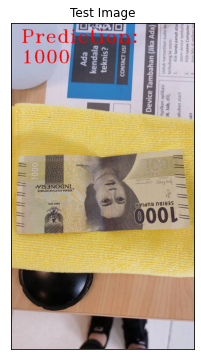

In [26]:
plt.figure(1, figsize=(6, 6))
plt.imshow(image1)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

#### 8. Performance Metrics

For performance metrics, we are getting the data based on the prediction of the value of banknotes in our testing dataset.
The process for image preparation and feature extraction is roughly the same, but since the images in testing dataset has varying height and width, we have to resize the image into 1600x900 first (or 900x1600, depending on the orientation of the original image), only then we could resize the image again into 9% of the resized image. 

For clustering, we are using the model that we have saved on .pkl file and then we calculate the amount of features in each cluster using Bag of Visual Words. With the features, we could put it into the SVC model and predict the value of banknotes. 

In [27]:
TEST_PATH = './dataset rupiah TE 2016/test/'
DATASET_PATH = './dataset rupiah TE 2016/train/'

test_image_path = os.listdir(TEST_PATH)
test_images = []
test_classes = []
test_descriptors = []
train_list = os.listdir(DATASET_PATH)

sift = cv2.SIFT_create()

for img in test_image_path:
    image1 = cv2.imread(TEST_PATH + img)

    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    
    h, w = image_gray.shape
    if h > w:
        image_gray = cv2.resize(image_gray, (900, 1600))
    else:
        image_gray = cv2.resize(image_gray, (1600, 900))
    
    h, w = image_gray.shape
    h = int(h * 30 / 100)
    w = int(w * 30 / 100)
    image_gray = cv2.resize(image_gray, (w, h))
    
    test_desc = apply_sift(image_gray)
    test_desc = apply_rootsift(test_desc)
    
    # get image class
    img_class_text = img.split(' ')[0]
    img_class = train_list.index(img_class_text)
    test_classes.append(img_class)
    
    test_images.append(image1)
    test_descriptors.append(test_desc)

    
centroid = load_model()
test_features = bow(test_images, centroid, test_descriptors, '')
test_features = normalize_histogram(test_images, test_features)

Predicting value of banknotes using method predict on SVC model.

In [28]:
result = svc.predict(test_features)

Then we would like to display all images in the test set along with its prediction result, thus we use plt.figure() function and set its size into 20x60 inches that consists of 21 rows and 3 columns (63 subplots). We specify the location of each subplot. We do a looping through all images in the array using enumerate(). We specify the location of each subplot. To show the image, we use plt.imshow(). We define the plt.xticks([]) and plt.yticks([]) as we don't want to display the number line.

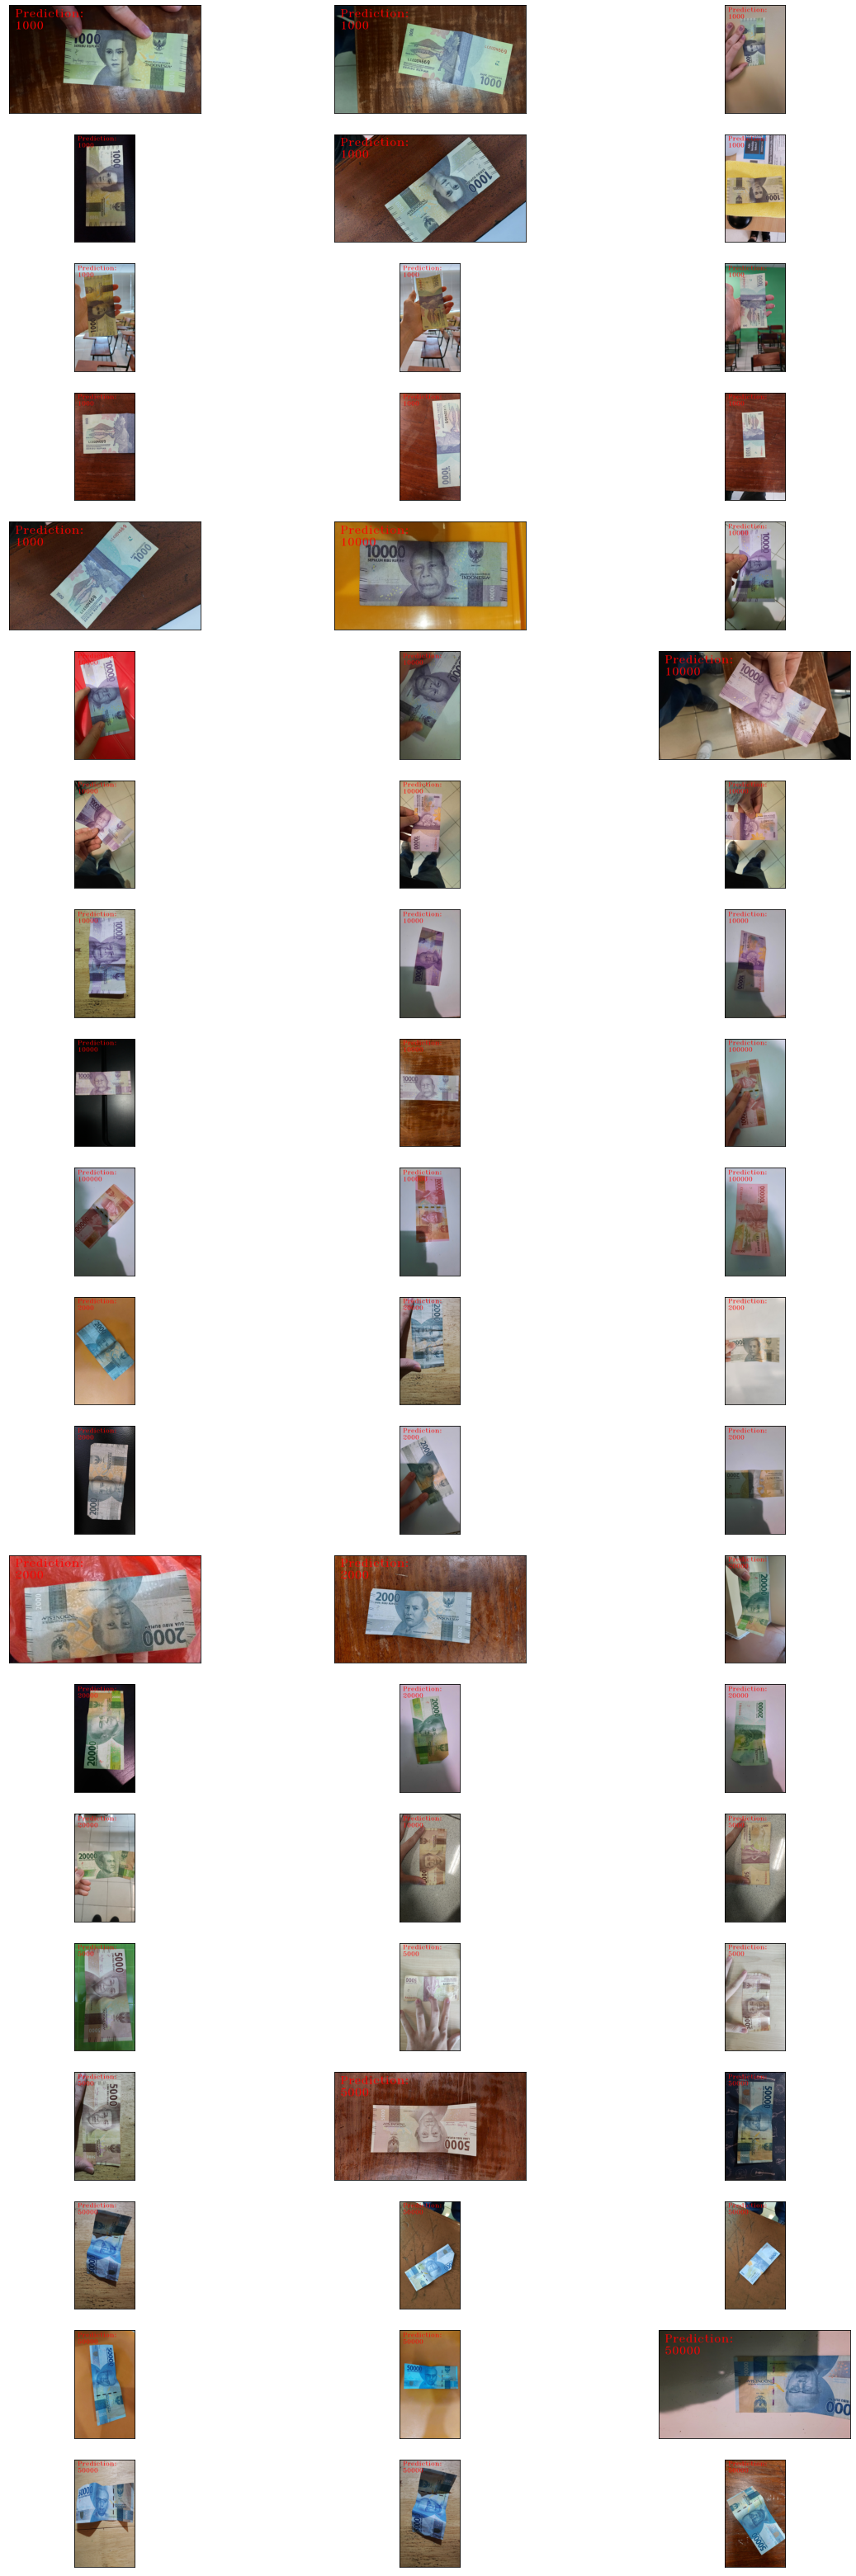

In [29]:
plt.figure(1, figsize=(20, 60))
plt.tight_layout()

for idx, img in enumerate(test_image_path):
    img = cv2.imread(TEST_PATH + img)
    img = resize_image(img, 900, 1600)
    img = annotate_image(img, train_list, result[idx])
    
    plt.subplot(21, 3, idx+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

Now, we will evaluate our model by comparing the ground truth and the predicted result. Confusion matrix is used for performance measurement for machine learning classification problem where output can be two or more classes. First, we will make a confusion matrix using the confusion_matrix() function. It accepts 2 parameters, the ground truth (actual value) and (predicted) result. Then, we convert it into a form of Pandas dataframe as it will make us easier to analyze, clean, transform, explore, and manipulate the data. Lastly, we represent the confusion matrix as a heatmap using Seaborn where the index and column are gained from the classes name. We also add some annotation to easier the analysis process.

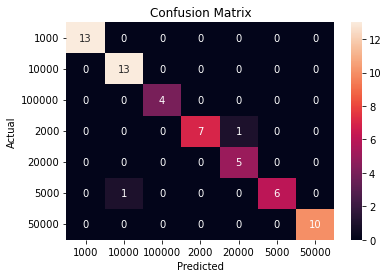

In [30]:
cnf_matrix = confusion_matrix(test_classes, result)

cnf_matrix = pd.DataFrame(
    cnf_matrix,
    index = train_list,
    columns = train_list
)

plt.title('Confusion Matrix')
sns.heatmap(cnf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Then, we could also build a text report showing the main classification metrics. A classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False.
- True Positive (TP) is an outcome where the model correctly predicts the positive class.
- True Negative (TN) is an outcome where the model correctly predicts the negative class.
- False Positive (FP) is an outcome where the model incorrectly predicts the positive class.
- False Negative (FN) is an outcome where the model incorrectly predicts the negative class.

From the confusion matrix, we could calculate the accuracy, precision, recall, and f1-score of the model.
- Accuracy is the ratio between the number of correct predictions from all the predictions made. Accuracy is often presented as a percentage between 0% for the worst possible accuracy and 100% for the best accuracy. In short, accuracy can be obtained with (correct predictions / total predictions * 100).
Accuracy = (TP + TN) / (TP + FP + FN + TN)<br>

- Presicion represents how many proportion of positive identifications are actually correct. Precision represents how well the model predicts certain categories.<br>
Precision = TP / (TP + FP)

- Recall represents how many actual positive proportions can be correctly identified. Recall represents the number of times the model can detect a certain category.<br>
Recall = TP / (TP + FN)

- F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. It is primarily used to compare the performance of two classifiers.<br>
F1-Score = (2 * precision * recall) / (precision + recall)

In [31]:
print(classification_report(test_classes, result))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      1.00      0.96        13
           2       1.00      1.00      1.00         4
           3       1.00      0.88      0.93         8
           4       0.83      1.00      0.91         5
           5       1.00      0.86      0.92         7
           6       1.00      1.00      1.00        10

    accuracy                           0.97        60
   macro avg       0.97      0.96      0.96        60
weighted avg       0.97      0.97      0.97        60



#### 9. GUI

The GUI (Graphical User Interface) is built using Tkinter library and we store it into buildGUI() function. In the main menu display, there are 3 buttons, Upload Image, Make Prediction, and Show Confusion Matrix. Make Prediction button remains in the disabled state until the Upload Image button is ran (there is uploaded image).

If we click the Upload Image button, there are a pop-up window to select an image that would be processed. We can select the images in .jpg, .jpeg, and .png format. After selecting an image, the program will resize it into 180x320 or 320x128 based on the orientation and display it on GUI. Then, the Make Prediction button is on normal state (clickable).

If we click the Make Prediction button, it will call all the aforementioned function in the source code to perform the prediction, such as resizing into 16:9 or 9:16, converting into grayscale, resizing into 9% from its original size, applying SIFT and RootSIFT algorithm, applying Bag of Visual Words, applying SVC, annotating the image, and saving the image into disk. Then, we could display the image into the GUI by resizing it into 180x320 or 320x128 based on the orientation and display it on GUI.

If we click the Show Confusion Matrix button, it will call the makeConfusion() function and show a confusion matrix that we have calculated beforehand, based on the test dataset. Confusion matrix shows the ground truth value of each banknotes and the predicted result.

In [32]:
gui_img_global = None
resize_image = None
filename = None
img_input_canvas = None
img_prediction_canvas = None

def buildGUI():
    root = tk.Tk()

    root.title("Indonesian Banknote Value Detector")
    root.iconbitmap(r'asset/banknote.ico')
    root.geometry('900x600')
    root.resizable(width = False, height = False)

    header = TkFont.Font(family = "San Francisco", size = 24, weight = "bold")
    subheader = TkFont.Font(family = "San Francisco", size = 10)
    body = TkFont.Font(family = "San Francisco", size = 8)

    canvas1 = tk.Canvas(root, width = 900, height = 600)
    canvas1.pack()
    
    title = tk.Label(text = "Indonesian Banknote Value Detector", font = header)
    canvas1.create_window(450, 40, window = title)
    
    def def_orientation(image):
        height = image.shape[0]
        width = image.shape[1]

        if height > width:
            orientation = "portrait"
        else:
            orientation = "landscape"
        return orientation
    
    def resize_image_gui(image, orientation, small, large):
        if (orientation == "portrait"):
            image = image.resize((small, large))
        else:
            image = image.resize((large, small))
        return image
    
    def upload_file():
        global img_input_canvas
        global gui_img_global
        global resize_image
        global filename
        
        if img_input_canvas:
            canvas1.delete(img_input_canvas)
        
        f_types = [('JPG Files', '*.jpg'),
                   ('JPEG Files', '*.jpeg'),
                   ('PNG Files', '*.png'),
                  ]
        filename = filedialog.askopenfilename(title = 'Select file', filetypes = f_types)
        gui_img_global = cv2.imread(filename)
        orientation = def_orientation(gui_img_global)
        
        if filename:
            filepath = os.path.abspath(filename)
        
        image = Image.open(filepath)
        resize_image = resize_image_gui(image, orientation, 180, 320)
        display = ImageTk.PhotoImage(resize_image)

        label1 = tk.Label(image=display)
        label1.image = display
        img_input_canvas = canvas1.create_window(225, 350, window = label1)
        
        button2['state'] = tk.NORMAL
        
    def makePrediction():
        global img_prediction_canvas
        global gui_img_global
        if img_prediction_canvas:
            canvas1.delete(img_prediction_canvas)
        
        h, w = gui_img_global.shape[:2]
        if h > w:
            gui_img_global = cv2.resize(gui_img_global, (900, 1600))
        else:
            gui_img_global = cv2.resize(gui_img_global, (1600, 900))
        
        gui_image_gray = convert_to_grayscale(gui_img_global)
        
        h, w = gui_image_gray.shape
        h = int(h * 30 / 100)
        w = int(w * 30 / 100)
        gui_image_gray = cv2.resize(gui_image_gray, (w, h))
        gui_test_desc = apply_sift(gui_image_gray)
        gui_test_desc = apply_rootsift(gui_test_desc)
        centroid = load_model()
        gui_test_feature = bow(gui_img_global, centroid, gui_test_desc, "testing")
        gui_result = svc.predict(gui_test_feature)
        gui_train_list = os.listdir(dataset_path)
        gui_image_res = annotate_image(cv2.cvtColor(gui_img_global, cv2.COLOR_BGR2RGB), gui_train_list, gui_result[0])
        cv2.imwrite("result.jpg", gui_image_res)

        filepath2 = os.path.abspath("result.jpg")
        image2 = Image.open(filepath2)
        orientation = def_orientation(gui_image_res)
        resize_image2 = resize_image_gui(image2, orientation, 180, 320)
        display2 = ImageTk.PhotoImage(resize_image2)

        label2 = tk.Label(image=display2)
        label2.image = display2
        img_prediction_canvas = canvas1.create_window(675, 350, window = label2)
        
    def makeConfusion():
        root = tk.Tk()
        root.title('Confusion Matrix')
        root.iconbitmap(r'asset/banknote.ico')
        root.geometry('430x430')
        root.resizable(width = False, height = False)

        figure1 = plt.figure(figsize=(6,6))
        ax1 = figure1.add_subplot()
        bar1 = FigureCanvasTkAgg(figure1, root)
        bar1.get_tk_widget().place(x = 0, y = 0)
        df1 = sns.heatmap(cnf_matrix, fmt = '', annot=True)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        ax1.set_title('Confusion Matrix')
        root.mainloop()

    button1 = tk.Button(root, text = "Upload Image", font = subheader, command = upload_file, fg = "white", bg = "black", activebackground = "white", activeforeground = "black")
    canvas1.create_window(225, 150, window = button1)
    
    button2 = tk.Button(root, text = "Make Prediction", font = subheader, command = makePrediction, fg = "white", bg = "black", activebackground = "white", activeforeground = "black", state = tk.DISABLED)
    canvas1.create_window(675, 150, window = button2)
    
    button3 = tk.Button(root, text = "Show Confusion Matrix", font = subheader, command = makeConfusion, fg = "white", bg = "black", activebackground = "white", activeforeground = "black")
    canvas1.create_window(450, 500, window = button3)
    
    root.mainloop()

In [33]:
if __name__ == '__main__':
    buildGUI()